#1. 환경설정   
- 구글 드라이브 경로 설정 

In [1]:
from google.colab import drive

drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [2]:
DATA_PATH = '/content/gdrive/My Drive/DACON/sea_ice/data/train_v2.csv'
DIR_PATH = '/content/gdrive/My Drive/DACON/sea_ice/data/'
DIR_TRAIN_PATH = '/content/gdrive/My Drive/DACON/sea_ice/data/train_data_v2/'
MODEL_PATH='/content/gdrive/My Drive/DACON/sea_ice/model/'
SUBMISSION_PATH='/content/gdrive/My Drive/DACON/sea_ice/submission/'

 - Library Import

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Conv3D, ConvLSTM2D, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam

 - TPU 사용 설정

In [4]:
#TPU 설정
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  
    # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 
    # default distribution strategy in Tensorflow. Works on CPU and single GPU.
print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.16.187.202:8470
INFO:tensorflow:Initializing the TPU system: grpc://10.16.187.202:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.16.187.202:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS:  8


#2. Data Load  
 - 30년 데이터 사용

In [5]:
train_path = sorted(glob(DIR_TRAIN_PATH+'*.npy'))
train_path = train_path[-30*12:]

In [6]:
train = []
for p in tqdm(train_path):
    train.append(np.load(p))
train = np.array(train)

100%|██████████| 360/360 [02:38<00:00,  2.27it/s]


In [7]:
MAP_ROW_SIZE = train.shape[1]
MAP_COL_SIZE = train.shape[2]

#3. 데이터 전처리 
 - 북극점 미관측영역을 결빙도 250으로 채우기

In [8]:
train[:, :, :, 0] = train[:,:,:,0] + train[:,:,:,1] * 250

 - 월별 데이터로 분리

In [9]:
train_month = []
for i in range(12):
    train_month.append(train[i::12, :,:])
train_month = np.array(train_month)

In [10]:
train_month.shape

(12, 30, 448, 304, 5)

 - stride 크기대로 이미지를 자를 수 있도록 패딩추가

In [11]:
stride = 32

In [12]:
temp = np.zeros([train_month.shape[0],
                 train_month.shape[1],
                 train_month.shape[2]+(stride-train_month.shape[2]%stride),
                 train_month.shape[3]+(stride-train_month.shape[3]%stride),
                 train_month.shape[4]], np.uint8)
temp[:, :,:train_month.shape[2], :train_month.shape[3], :] = train_month
train_month = temp
del temp

In [13]:
train_month.shape

(12, 30, 480, 320, 5)

 - window size대로 학습데이터 설정

In [14]:
window_size = 5

In [15]:
x_train = []
y_train = []

for i in range(train_month.shape[1]-window_size):
    x_train.append(train_month[:, i: i+window_size,:,:,:])
    y_train.append(train_month[:, i+window_size: i+window_size+1,:,:,:])

x_train = np.array(x_train)
y_train = np.array(y_train)    

 - feature size 대로 데이터 자르기

In [16]:
feature_size = 128

In [17]:
x_train_ = []
y_train_ = []
for y in range(x_train.shape[0]):
    for m in range(12):
        for i in range((x_train.shape[3]-feature_size)//stride+1):
            for j in range((x_train.shape[4]-feature_size)//stride+1):
                x_ = x_train[y, m, :, stride*i:stride*i+feature_size, stride*j:stride*j+feature_size, :1]
                y_ = y_train[y, m, :, stride*i:stride*i+feature_size, stride*j:stride*j+feature_size, :1]
                x_train_.append(x_)
                y_train_.append(y_)

x_train_ = np.array(x_train_)
y_train_ = np.array(y_train_)

x_val_ = []
y_val_ = []

for m in range(12):
    for i in range((x_train.shape[3]-feature_size)//stride+1):
        for j in range((x_train.shape[4]-feature_size)//stride+1):
            x_ = x_train[-1, m, :, stride*i:stride*i+feature_size, stride*j:stride*j+feature_size, :1]
            y_ = y_train[-1, m, :, stride*i:stride*i+feature_size, stride*j:stride*j+feature_size, :1]
            x_val_.append(x_)
            y_val_.append(y_)
            
x_val_ = np.array(x_val_)
y_val_ = np.array(y_val_)

In [18]:
x_train_.shape, y_train_.shape, x_val_.shape, y_val_.shape

((25200, 5, 128, 128, 1),
 (25200, 1, 128, 128, 1),
 (1008, 5, 128, 128, 1),
 (1008, 1, 128, 128, 1))

 - 학습데이터 시각화

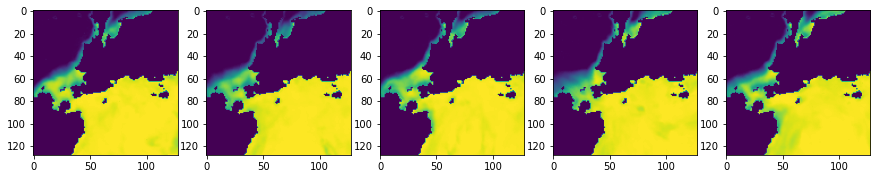

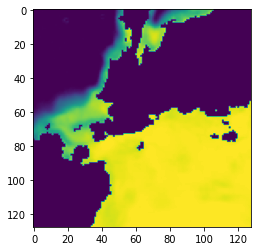

In [19]:
i = 22
plt.figure(figsize=(15,10))
for y in range(x_train_.shape[1]):
    plt.subplot(1,window_size,y+1)
    plt.imshow(x_train_[i,y,:,:,0])
plt.show()
plt.imshow(y_train_[i,-1,:,:,0])

 - 데이터셋 만들기

In [20]:
BATCH_SIZE = 32

In [21]:
def train_map_func(x,y):
    x = tf.cast(x, tf.float32)/250
    y = tf.cast(y, tf.float32)
    return x,y

In [22]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_, y_train_))
train_dataset = train_dataset.map(train_map_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((x_val_, y_val_))
val_dataset = val_dataset.map(train_map_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [23]:
next(iter(train_dataset))[0].shape, next(iter(train_dataset))[1].shape

(TensorShape([32, 5, 128, 128, 1]), TensorShape([32, 1, 128, 128, 1]))

In [24]:
next(iter(val_dataset))[0].shape, next(iter(val_dataset))[1].shape

(TensorShape([32, 5, 128, 128, 1]), TensorShape([32, 1, 128, 128, 1]))

#4. 모델 생성

In [25]:
model_name_1 = "convlstm_model_20210407_1"
model_name_2 = "convlstm_model_20210407_2"

In [26]:
def makemodel():
    with strategy.scope():
        model = tf.keras.Sequential(
            [
                tf.keras.Input(
                 shape=(None, x_train_.shape[2], x_train_.shape[3], 1)
                ),  # Variable-length sequence of 40x40x1 frames
                tf.keras.layers.ConvLSTM2D(
                    filters=64, kernel_size=3, padding="same", return_sequences=True
                ), 
                tf.keras.layers.BatchNormalization(), 
                tf.keras.layers.ConvLSTM2D(
                    filters=64, kernel_size=3, padding="same", return_sequences=True
                ),
                tf.keras.layers.BatchNormalization(), 
                tf.keras.layers.ConvLSTM2D(
                    filters=64, kernel_size=3, padding="same", return_sequences=True
                ),
                tf.keras.layers.BatchNormalization(),  
                tf.keras.layers.Conv3D(
                    filters=1, kernel_size=3, activation="relu", padding="same",  data_format='channels_last'
                ), 
            ]
        ) 
        model.compile(loss='mae', optimizer=Adam())
 
    return model

#5. 학습
 - 1번째 학습

In [ ]:
model = makemodel()
#model.summary()

In [ ]:
#model.save_weights(MODEL_PATH + 'model_init_20210407_1.h5')
model.load_weights(MODEL_PATH + 'model_init_20210407_1.h5')

In [ ]:
tf.keras.backend.clear_session()
callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath = MODEL_PATH + model_name_1  + ".h5",
        monitor='val_loss',
        save_best_only=True
    )
]

model.fit(train_dataset, epochs=20, validation_data=val_dataset, callbacks=callbacks_list)

 - 2번째 학습

In [ ]:
model = makemodel()
#model.summary()

In [ ]:
#model.save_weights(MODEL_PATH + 'model_init_20210407_2.h5')
model.load_weights(MODEL_PATH + 'model_init_20210407_2.h5')

In [ ]:
tf.keras.backend.clear_session()
callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath = MODEL_PATH + model_name_2  + ".h5",
        monitor='val_loss',
        save_best_only=True
    )
]

model.fit(train_dataset, epochs=20, validation_data=val_dataset, callbacks=callbacks_list)

Epoch 1/20
788/788 [==============================] - 409s 488ms/step - loss: 19.0095 - val_loss: 7.2961
Epoch 2/20
788/788 [==============================] - 342s 434ms/step - loss: 8.0484 - val_loss: 6.4011
Epoch 3/20
788/788 [==============================] - 342s 434ms/step - loss: 7.3549 - val_loss: 6.1907
Epoch 4/20
788/788 [==============================] - 342s 434ms/step - loss: 6.3546 - val_loss: 5.3926
Epoch 5/20
788/788 [==============================] - 342s 434ms/step - loss: 5.8893 - val_loss: 5.0795
Epoch 6/20
788/788 [==============================] - 342s 434ms/step - loss: 5.7156 - val_loss: 4.8000
Epoch 7/20
788/788 [==============================] - 342s 434ms/step - loss: 5.6032 - val_loss: 4.6665
Epoch 8/20
788/788 [==============================] - 342s 434ms/step - loss: 5.4795 - val_loss: 4.6672
Epoch 9/20
788/788 [==============================] - 342s 434ms/step - loss: 5.4067 - val_loss: 4.4160
Epoch 10/20
788/788 [==============================] - 342s 434

#6. 추론   

 - 2020년 추론 데이터 전처리




In [27]:
x_test = train_month[:,-1*window_size:,:,:,:1]
x_test = np.swapaxes(x_test , 0, 1)

x_test_ = []
for m in range(12):
    feature = []
    for i in range((x_train.shape[3]-feature_size)//stride+1):
        for j in range((x_train.shape[4]-feature_size)//stride+1):
            x_ = x_test[:, m, stride*i:stride*i+feature_size, stride*j:stride*j+feature_size, :1]/250
            feature.append(x_)
    feature = np.array(feature)
    x_test_.append(feature)
x_test_ = np.array(x_test_)

In [28]:
x_test_.shape

(12, 84, 5, 128, 128, 1)

 - TTS

In [29]:
voting_mask = np.zeros((x_train.shape[-3], x_train.shape[-2]))
ones = np.ones((feature_size, feature_size))

for i in range((x_train.shape[3]-feature_size)//stride+1):
    for j in range((x_train.shape[4]-feature_size)//stride+1):
        voting_mask[stride*i:stride*i+feature_size, stride*j:stride*j+feature_size] += ones

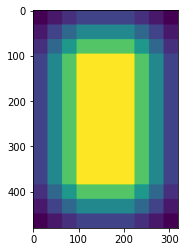

In [30]:
plt.imshow(voting_mask)

 - 1번째 예측

In [31]:
model = load_model(MODEL_PATH +  model_name_1  + ".h5") 

preds = []
for m in tqdm(range(12)):
    pred = model.predict(x_test_[m])
    pred = np.where(pred>250, 250, pred)
    preds.append(pred)

results_1 = []
for m in range(12):
    pred = np.zeros((x_train.shape[-3], x_train.shape[-2]))
    k = 0
    for i in range((x_train.shape[3]-feature_size)//stride+1):
        for j in range((x_train.shape[4]-feature_size)//stride+1):
            pred[stride*i:stride*i+feature_size, stride*j:stride*j+feature_size] += preds[m][k,-1,:,:,0]
            k+=1
    pred /= voting_mask
    results_1.append(pred[:MAP_ROW_SIZE, :MAP_COL_SIZE])
results_1 = np.array(results_1)    

100%|██████████| 12/12 [01:34<00:00,  7.88s/it]


 - 2번째 예측


In [32]:
model = load_model(MODEL_PATH +  model_name_2  + ".h5")

preds = []
for m in tqdm(range(12)):
    pred = model.predict(x_test_[m])
    pred = np.where(pred>250, 250, pred)
    preds.append(pred)

results_2 = []
for m in range(12):
    pred = np.zeros((x_train.shape[-3], x_train.shape[-2]))
    k = 0
    for i in range((x_train.shape[3]-feature_size)//stride+1):
        for j in range((x_train.shape[4]-feature_size)//stride+1):
            pred[stride*i:stride*i+feature_size, stride*j:stride*j+feature_size] += preds[m][k,-1,:,:,0]
            k+=1
    pred /= voting_mask
    results_2.append(pred[:MAP_ROW_SIZE, :MAP_COL_SIZE])
results_2 = np.array(results_2) 

100%|██████████| 12/12 [01:34<00:00,  7.85s/it]


 - 데이터 결합

In [33]:
results2020 = []
results2020 = results_1 * 0.5 + results_2 * 0.5

In [34]:
results_1.sum(), results_2.sum(), results2020.sum()

(40814233.77485474, 40188648.622642666, 40501441.19874871)

#7. 후처리

 -  2019년 12월 Data Load

In [35]:
train = pd.read_csv(DIR_PATH + 'train_v2.csv')

#north_pole_mask from 2019 December
data_dec = np.load(DIR_TRAIN_PATH+train['file_nm'][493]) 

 - 후처리 1: 북극점 미관측영역 마스크 만들기  및 적용

In [36]:
north_pole_mask = data_dec[:, :, 1] * -1 + 1

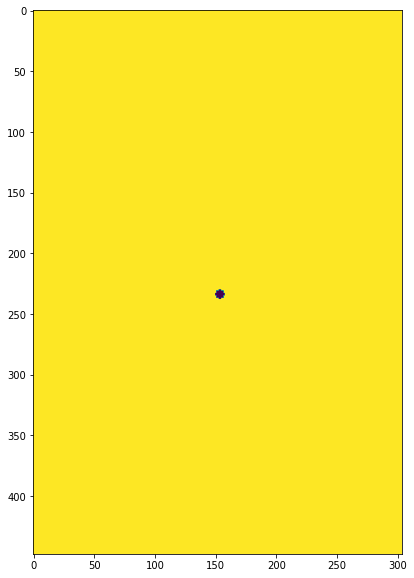

In [37]:
plt.figure(figsize = (20,10))
tmpimg = north_pole_mask
plt.imshow(tmpimg)

In [38]:
for m in range(12):
    results2020[m, : , : ] = results2020[m, : , : ] * north_pole_mask

 - 후처리 2: 육지 + 해안선 마스크 만들기 및 적용



In [39]:
landmask = ((data_dec[:, :, 2] + data_dec[:, :, 3])-1)/255

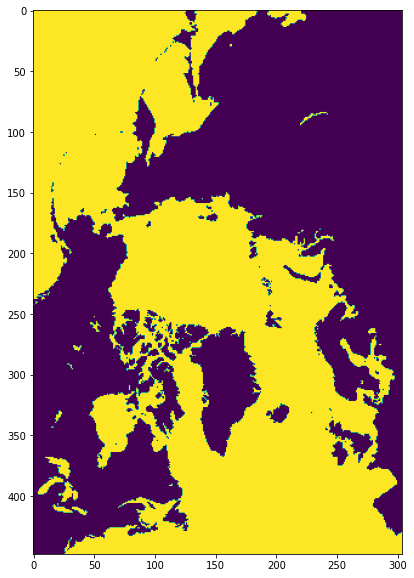

In [40]:
plt.figure(figsize = (20,10))
tmpimg = landmask
plt.imshow(tmpimg)

In [41]:
for m in range(12):
    results2020[m, : , : ] = results2020[m, : , : ] * landmask

In [42]:
results2020.sum()

40368424.2868078

#8. 추론 결과 확인

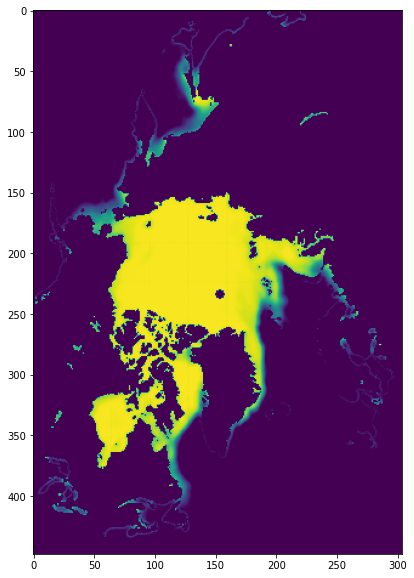

1 



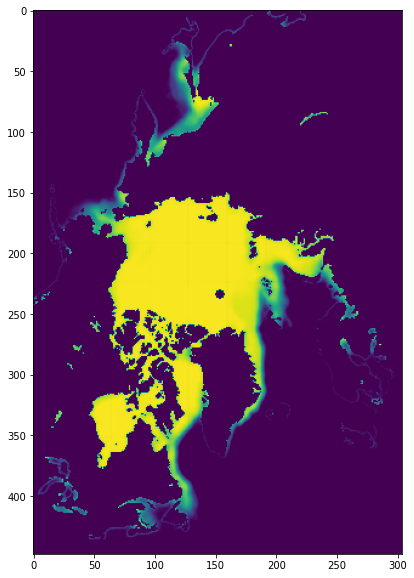

2 



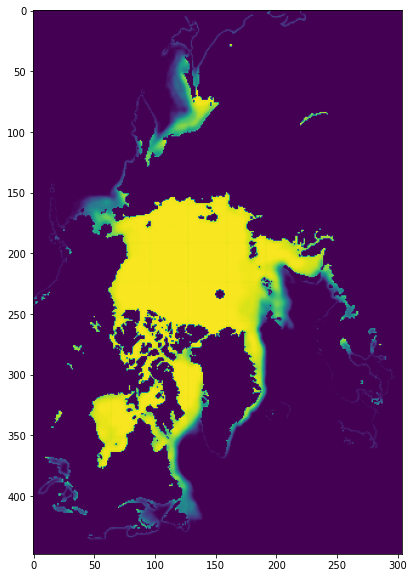

3 



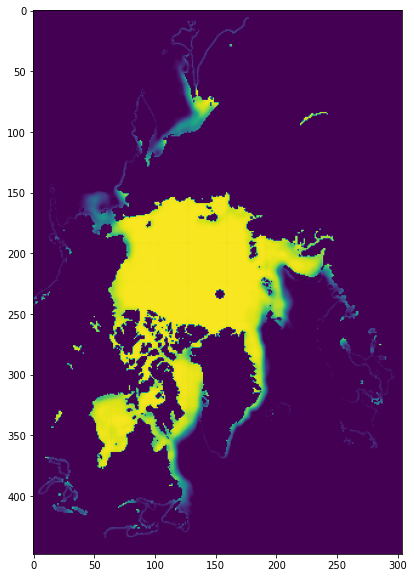

4 



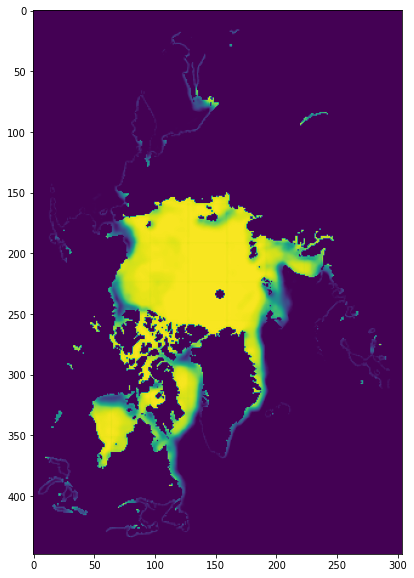

5 



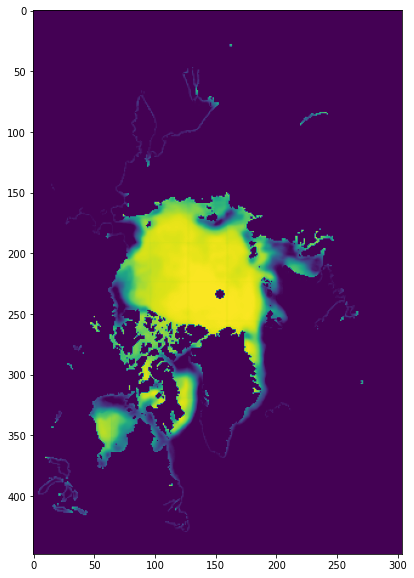

6 



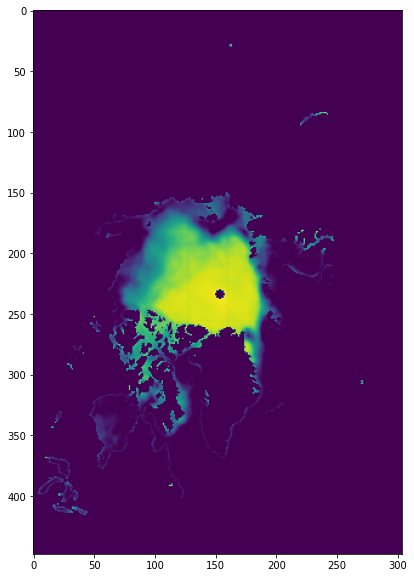

7 



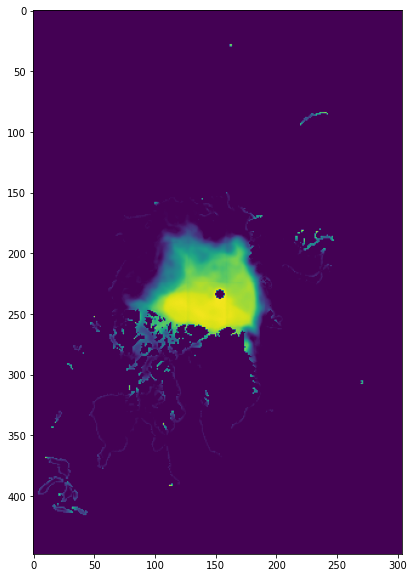

8 



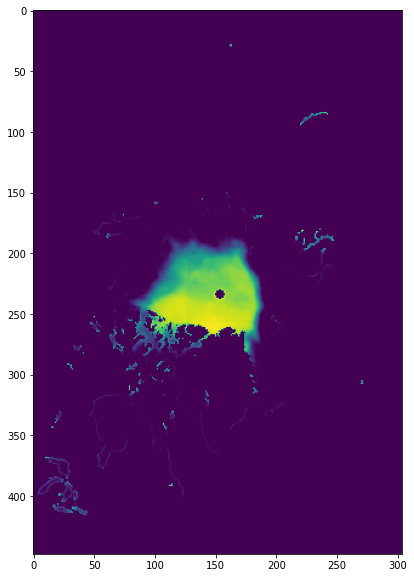

9 



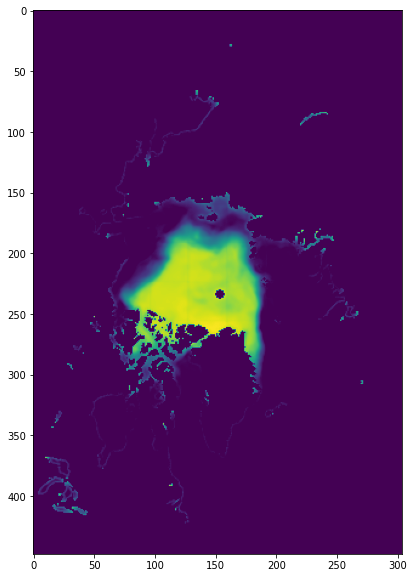

10 



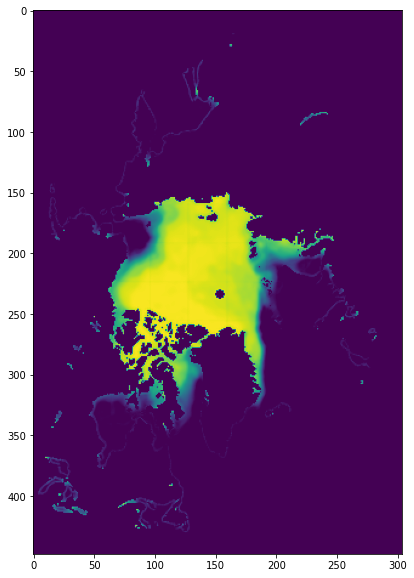

11 



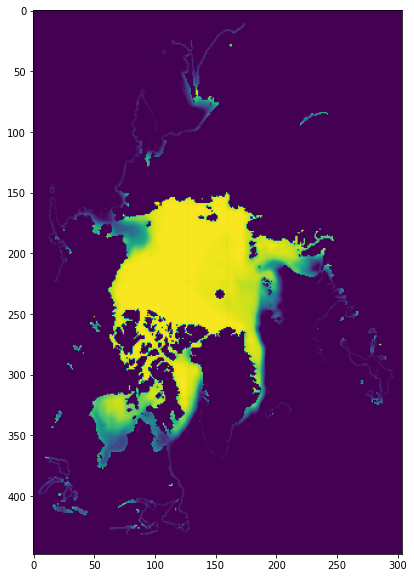

12 



In [43]:
for m in range(12):
    plt.figure(figsize = (20,10))
    plt.imshow(results2020[m])
    plt.show()
    print(m+1, '\n')

#9. 제출 파일 생성

In [44]:
submission = pd.read_csv(DIR_PATH+'sample_submission.csv')
#submission

In [45]:
results_2019 = []
for m in range(12): 
    data_2019 = np.load(DIR_TRAIN_PATH+train['file_nm'][482 + m])   
    results_2019.append(data_2019[:, :, 0])
results_2019 = np.array(results_2019) 

In [46]:
results = np.append(results_2019 ,  results2020)

In [47]:
results = results.reshape(24,448, 304 )

In [48]:
results.shape

(24, 448, 304)

In [49]:
submission_final = submission.loc[:, ['month']].copy()
submission_final = pd.concat([submission_final, (pd.DataFrame(results.reshape([24,-1])))], axis=1)
submission_final.columns = submission.columns

In [52]:
file_path =  SUBMISSION_PATH + "ConvLSTM_20210407"  + ".csv"
submission_final.to_csv(file_path, index=False, header=True)

In [53]:
file_path

'/content/gdrive/My Drive/DACON/sea_ice/submission/ConvLSTM_20210407.csv'